In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
# Rutas completas
TRAIN_PATH = r"C:\Users\maria\OneDrive\Documentos\AnotherSigma\PONTIA\PROYECTO JUPITER\archive\train"
TEST_PATH = r"C:\Users\maria\OneDrive\Documentos\AnotherSigma\PONTIA\PROYECTO JUPITER\archive\test"
BASE_PATH = r"C:\Users\maria\OneDrive\Documentos\AnotherSigma\PONTIA\PROYECTO JUPITER\archive"

In [3]:
# Definir las dimensiones de las imágenes (48x48, 1 canal para escala de grises)
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 32
CHANNELS = 1  # Escala de grises

In [4]:
# Definir las clases (emociones en inglés)
CLASSES = ['surprise', 'happy', 'neutral', 'angry', 'fear', 'sad', 'disgust']

In [5]:
# Crear generadores de datos con aumentación (mismo nivel que el modelo original)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [6]:
# Generador para el conjunto de entrenamiento
train_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='training',
    shuffle=True
)

Found 22968 images belonging to 7 classes.


In [7]:
# Generador para el conjunto de validación
validation_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='validation',
    shuffle=False
)

Found 5741 images belonging to 7 classes.


In [8]:
# Generador para el conjunto de prueba (sin aumentación)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    shuffle=False
)


Found 7178 images belonging to 7 classes.


In [9]:
# Obtener el número de clases y el mapeo de clases
num_classes = len(CLASSES)
class_indices = train_generator.class_indices
print("Número de clases:", num_classes)
print("Clases:", class_indices)

Número de clases: 7
Clases: {'surprise': 0, 'happy': 1, 'neutral': 2, 'angry': 3, 'fear': 4, 'sad': 5, 'disgust': 6}


In [10]:
# Implementar Focal Loss
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # Convertir y_true y y_pred a float32 para evitar problemas de tipo
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Clip para evitar log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        
        # Calcular la pérdida de entropía cruzada
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Calcular el factor de focal loss
        weight = alpha * y_true * tf.pow(1.0 - y_pred, gamma)
        
        # Calcular la pérdida focal
        loss = weight * cross_entropy
        
        # Sumar a lo largo de las clases
        return tf.reduce_sum(loss, axis=-1)
    
    return focal_loss_fixed

In [11]:
# Construir la arquitectura Mini-Xception original
def mini_xception(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Primer bloque
    x = Conv2D(8, (3, 3), padding='same', strides=(1, 1), use_bias=False)(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), padding='same', strides=(1, 1), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Primer módulo residual
    residual = Conv2D(16, (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    residual = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(residual)

    x = SeparableConv2D(16, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Add()([x, residual])

    # Segundo módulo residual
    residual = Conv2D(32, (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    residual = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(residual)

    x = SeparableConv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Add()([x, residual])

    # Tercer módulo residual
    residual = Conv2D(64, (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    residual = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(residual)

    x = SeparableConv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Add()([x, residual])

    # Capa final
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

In [12]:
# Crear el modelo Mini-Xception
model = mini_xception(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), num_classes=num_classes)

In [13]:
# Compilar el modelo con Focal Loss
model.compile(optimizer=Adam(learning_rate=1e-3), loss=focal_loss(gamma=2.0, alpha=0.25), metrics=['accuracy'])

In [14]:
# Resumen del modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 8)    72          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 48, 48, 8)    0           ['batch_normalization[0][0]']

In [15]:
# Callbacks para entrenamiento
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(BASE_PATH, 'best_mini_xception_focal_loss_48x48.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

In [16]:
# Entrenar el modelo
# Cargar el mejor modelo guardado
model.load_weights(os.path.join(BASE_PATH, 'best_mini_xception_focal_loss_48x48.h5'))

Epoch 1/50
717/717 [==============================] - 661s 919ms/step - loss: 0.3272 - accuracy: 0.2388 - val_loss: 0.3135 - val_accuracy: 0.2563 - lr: 0.0010
Epoch 2/50
717/717 [==============================] - 661s 921ms/step - loss: 0.3129 - accuracy: 0.2573 - val_loss: 0.3046 - val_accuracy: 0.2671 - lr: 0.0010
Epoch 3/50
717/717 [==============================] - 654s 912ms/step - loss: 0.3051 - accuracy: 0.2718 - val_loss: 0.3104 - val_accuracy: 0.2627 - lr: 0.0010
Epoch 4/50
717/717 [==============================] - 653s 911ms/step - loss: 0.2989 - accuracy: 0.2845 - val_loss: 0.3134 - val_accuracy: 0.2701 - lr: 0.0010
Epoch 5/50
717/717 [==============================] - 664s 927ms/step - loss: 0.2945 - accuracy: 0.2967 - val_loss: 0.2985 - val_accuracy: 0.2828 - lr: 0.0010
Epoch 6/50
717/717 [==============================] - 656s 915ms/step - loss: 0.2888 - accuracy: 0.3068 - val_loss: 0.2886 - val_accuracy: 0.2788 - lr: 0.0010
Epoch 7/50
717/717 [==========================

In [17]:
# Cargar el mejor modelo guardado
model.load_weights(os.path.join(BASE_PATH, 'best_mini_xception_focal_loss_48x48.h5'))

In [18]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

225/225 [==============================] - 9s 38ms/step - loss: 0.1937 - accuracy: 0.5191
Test Loss: 0.1937
Test Accuracy: 0.5191


In [19]:
# Obtener predicciones y etiquetas reales
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

225/225 [==============================] - 6s 22ms/step


In [20]:
# Calcular métricas con Scikit-learn
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

Classification Report:
              precision    recall  f1-score   support

    surprise       0.55      0.76      0.64       831
       happy       0.74      0.81      0.77      1774
     neutral       0.46      0.62      0.53      1233
       angry       0.33      0.50      0.40       958
        fear       0.28      0.10      0.15      1024
         sad       0.50      0.25      0.33      1247
     disgust       0.00      0.00      0.00       111

    accuracy                           0.52      7178
   macro avg       0.41      0.43      0.40      7178
weighted avg       0.50      0.52      0.49      7178



C:\Users\maria\anaconda3\envs\pontia-ml\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\maria\anaconda3\envs\pontia-ml\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\maria\anaconda3\envs\pontia-ml\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [21]:
# Calcular F1-score promedio
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f"Weighted F1-Score: {f1:.4f}")

Weighted F1-Score: 0.4878


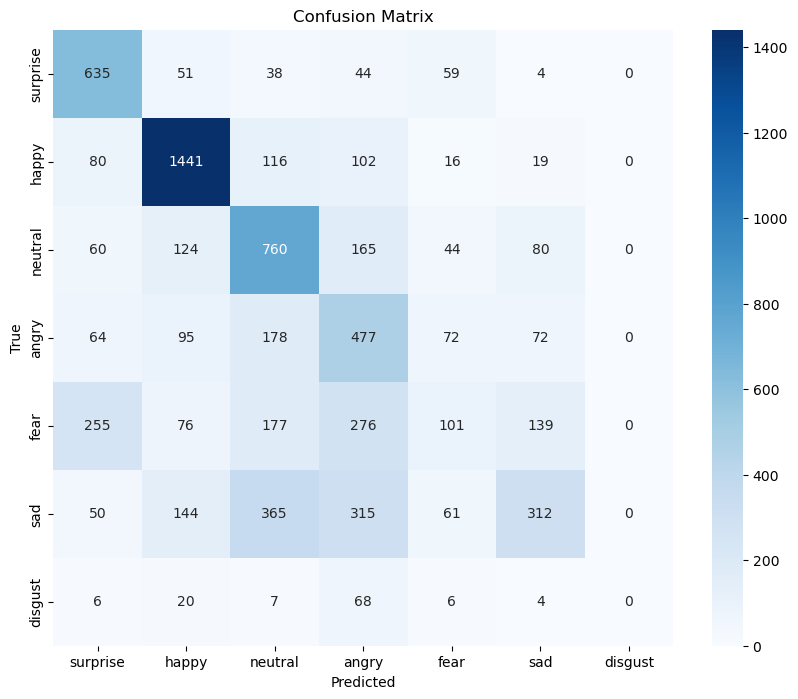

In [22]:
# Crear y mostrar la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
# Análisis de la matriz de confusión
print("Análisis de la matriz de confusión:")
for i, emotion in enumerate(CLASSES):
    true_positives = cm[i, i]
    false_positives = sum(cm[:, i]) - true_positives
    false_negatives = sum(cm[i, :]) - true_positives
    print(f"\n{emotion}:")
    print(f"  Verdaderos positivos: {true_positives}")
    print(f"  Falsos positivos: {false_positives}")
    print(f"  Falsos negativos: {false_negatives}")
    # Identificar clases con las que se confunde
    confusions = [(CLASSES[j], cm[i, j]) for j in range(len(CLASSES)) if j != i and cm[i, j] > 0]
    if confusions:
        print("  Se confunde con:")
        for conf_emotion, count in confusions:
            print(f"    - {conf_emotion}: {count} veces")

Análisis de la matriz de confusión:

surprise:
  Verdaderos positivos: 635
  Falsos positivos: 515
  Falsos negativos: 196
  Se confunde con:
    - happy: 51 veces
    - neutral: 38 veces
    - angry: 44 veces
    - fear: 59 veces
    - sad: 4 veces

happy:
  Verdaderos positivos: 1441
  Falsos positivos: 510
  Falsos negativos: 333
  Se confunde con:
    - surprise: 80 veces
    - neutral: 116 veces
    - angry: 102 veces
    - fear: 16 veces
    - sad: 19 veces

neutral:
  Verdaderos positivos: 760
  Falsos positivos: 881
  Falsos negativos: 473
  Se confunde con:
    - surprise: 60 veces
    - happy: 124 veces
    - angry: 165 veces
    - fear: 44 veces
    - sad: 80 veces

angry:
  Verdaderos positivos: 477
  Falsos positivos: 970
  Falsos negativos: 481
  Se confunde con:
    - surprise: 64 veces
    - happy: 95 veces
    - neutral: 178 veces
    - fear: 72 veces
    - sad: 72 veces

fear:
  Verdaderos positivos: 101
  Falsos positivos: 258
  Falsos negativos: 923
  Se confunde co